In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from PIL import Image 
import os 
from skimage.io import*
from skimage.transform import resize

In [2]:
img_files = []
for root, dirs, files in os.walk('/kaggle/input/spines/spine_data/Dataset Intensity/'):
    for file in files:
        if file.endswith('.png'):
            img_files.append(os.path.join(root, file))

label_files = []
for root, dirs, files in os.walk('/kaggle/input/spines/spine_data/Dataset Binary/'):
    for file in files:
        if file.endswith('.png'):
            label_files.append(os.path.join(root, file))

In [3]:
images = []
labels = []
#resize images and labels to 256x256
for i in range(len(img_files)):
    img = imread(img_files[i])
    img = resize(img, (256, 256))
    images.append(img)

    label = imread(label_files[i])
    label = resize(label, (256, 256))
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [4]:
def handle_grayscale_image(image):
    np_image = np.array(image)
    if np_image.ndim == 2:
        tiled_image = np.tile(np.expand_dims(np_image, -1), 3)
        return Image.fromarray((tiled_image*255).astype(np.uint8))
    else:
        return Image.fromarray(np_image)

In [5]:
dataset_dict = {
    'image':[handle_grayscale_image(image) for image in images],
    'label': [Image.fromarray((labels[i]).astype(np.uint8)) for i in range(labels.shape[0])]
}

In [6]:
from datasets import Dataset 
dataset = Dataset.from_dict(dataset_dict)
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 456
})

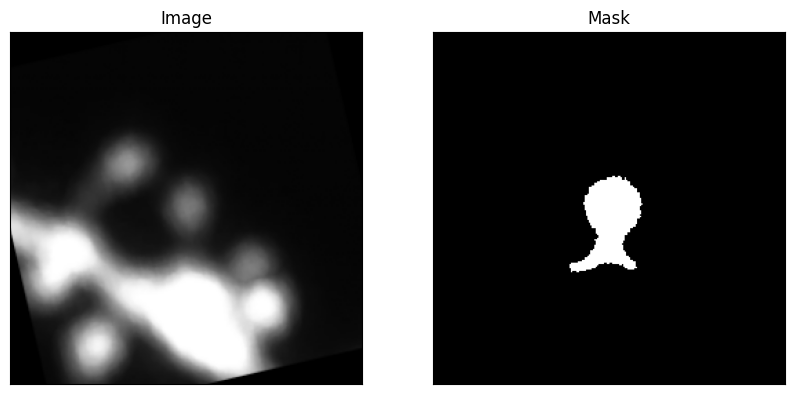

In [9]:
img_num = np.random.randint(0, len(dataset))
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show();

In [10]:
from torch.utils.data import Dataset
class SpineDataset(Dataset):
    def __init__(self,dataset,processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"]
        gt_label = np.array(sample["label"])
        #convert the mask to binary 0 and 1
        encoded_inputs = self.processor(image, gt_label,return_tensors="pt")
        encoded_inputs = {k:v.squeeze(0) for k,v in encoded_inputs.items()}
        return encoded_inputs

In [11]:
from transformers import SegformerImageProcessor
image_processor = SegformerImageProcessor(do_reduce_labels=False)
spine_dataset = SpineDataset(dataset, image_processor)

2024-03-27 04:20:13.008649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 04:20:13.008756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 04:20:13.171273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
encoded_inputs = spine_dataset[0]
encoded_inputs.keys()

dict_keys(['pixel_values', 'labels'])

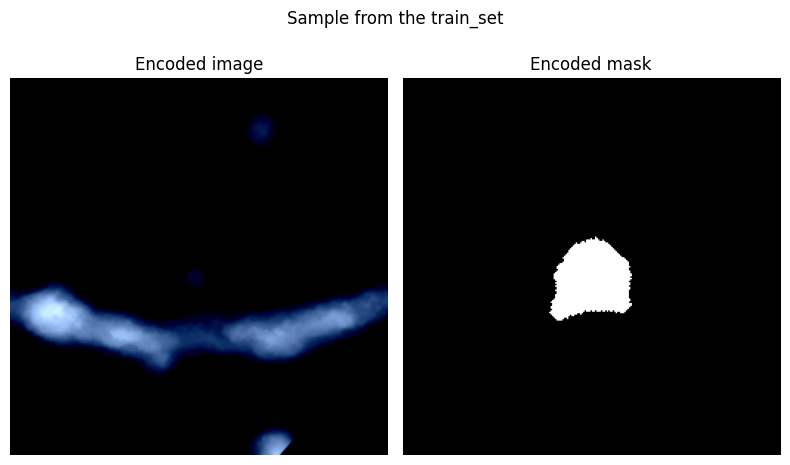

In [15]:
fig,ax = plt.subplots(1,2,figsize=(8,5))
ax[0].imshow(encoded_inputs['pixel_values'].permute(1,2,0))
ax[1].imshow(encoded_inputs['labels'],cmap='gray')
#ax[2].imshow(label2rgb(np.array(encoded_inputs['pixel_values'].permute(1,2,0)),np.array(encoded_inputs['labels']),bg_label=0,kind='overlay'))
ax[0].set_title('Encoded image')
ax[1].set_title('Encoded mask')
fig.suptitle('Sample from the train_set')
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show();

In [17]:
from torch.utils.data import DataLoader
train_loader = DataLoader(spine_dataset,batch_size=16,shuffle=True,num_workers=4)

In [19]:
! pip install evaluate -q

In [20]:
import evaluate
metric = evaluate.load("mean_iou")

In [21]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [22]:
id2label = {0:'bg',1:'spine'}
label2id = {v:k for k,v in id2label.items()}

print(label2id)

{'bg': 0, 'spine': 1}


In [23]:
from transformers import SegformerForSemanticSegmentation
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

In [24]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=2,
                                                         id2label=id2label,
                                                         label2id=label2id,
)
print_trainable_parameters(model)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.wei

trainable params: 3714658 || all params: 3714658 || trainable%: 100.00


In [26]:
! pip install peft -q

In [27]:
from peft import LoraConfig, get_peft_model
config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 528386 || all params: 4240996 || trainable%: 12.46


In [28]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from huggingface_hub import PyTorchModelHubMixin

In [29]:
class SpineSegmentationModel(pl.LightningModule, PyTorchModelHubMixin):
    def __init__(self,model,learning_rate, metric, id2label):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.metric = metric
        self.id2label = id2label
    
    def training_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = batch['labels']
        outputs = self.model(pixel_values=pixel_values, labels=labels)
        loss,logits = outputs.loss, outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        self.metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def on_training_epoch_end(self, outputs):
        metrics = self.metric._compute(
            predictions=self.metric.predictions,
            references=self.metric.references,
            num_labels=len(self.id2label),
            ignore_index=255,
            reduce_labels=False,
        )
        self.log("train_mean_iou", metrics["mean_iou"], prog_bar=True, logger=True)
        self.log("train_mean_accuracy", metrics["mean_accuracy"], prog_bar=True, logger=True)

    def configure_optimizers(self):
        return optim.AdamW(model.parameters(),lr = self.learning_rate)    

In [30]:
seg_model = SpineSegmentationModel(lora_model,learning_rate=0.0006,metric=metric,id2label=id2label)

In [31]:
seg_model

SpineSegmentationModel(
  (model): PeftModel(
    (base_model): LoraModel(
      (model): SegformerForSemanticSegmentation(
        (segformer): SegformerModel(
          (encoder): SegformerEncoder(
            (patch_embeddings): ModuleList(
              (0): SegformerOverlapPatchEmbeddings(
                (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
                (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
              )
              (1): SegformerOverlapPatchEmbeddings(
                (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              )
              (2): SegformerOverlapPatchEmbeddings(
                (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
              )
              (3): SegformerOver

In [36]:
trainer = pl.Trainer(max_epochs=10,accelerator='gpu',devices=2,callbacks=[ModelCheckpoint()])

In [38]:
print_trainable_parameters(lora_model)

trainable params: 528386 || all params: 4240996 || trainable%: 12.46


In [39]:
trainer.fit(seg_model,train_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [2, 256, 1, 1], strides() = [256, 1, 256, 256]
bucket_view.sizes() = [2, 256, 1, 1], strides() = [256, 1, 1, 1] (Triggered internally at /usr/local/src/pytorch/torch/csrc/distributed/c10d/reducer.cpp:320.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [2, 256, 1,

In [41]:
seg_model.save_pretrained("/kaggle/working/spine-segformer-lora")

In [42]:
trainer.save_checkpoint("/kaggle/working/spine-segformer-lora/seg_model.ckpt")

In [ ]:
sample_input = handle_grayscale_image(example_image)

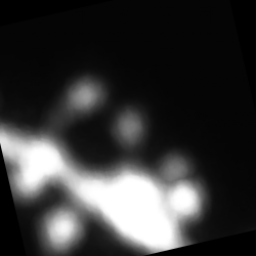

In [44]:
sample_input

In [50]:
seg_model.model = seg_model.model.eval()

In [51]:
pixel_values = image_processor(sample_input, return_tensors="pt")
outputs = seg_model.model(pixel_values=pixel_values.pixel_values)

In [52]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


In [53]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[sample_input.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [54]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

Text(0.5, 1.0, 'Example inference-Sample input with predicted mask')

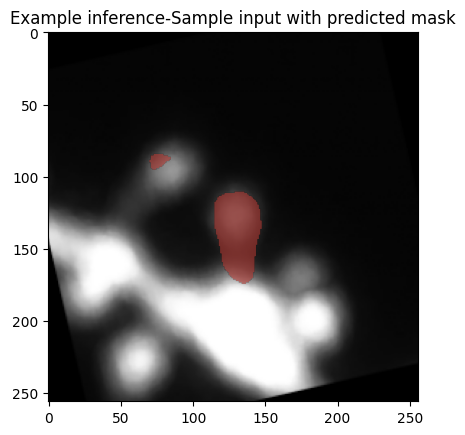

In [55]:
plt.imshow(sample_input)
show_mask(predicted_segmentation_map,plt.gca(),random_color=True)
plt.title('Example inference-Sample input with predicted mask')